# Accelerating krCalib map functions

# Author JJGC

## The problem 

- The strategy to compute mpas in KrCalib is to create a dictionary of selections and then operate over this dictionary. Consider for example that one wants to compute XY maps. One needs a matrix of selections. Each element of the matrix corresponds to a bin of X and a bin of Y. "Selection" means the events in the dst (a Pandas DataFrame) which have X and Y in that bin. A selection is nothing but a vector of bools, with the same lenght of the DataFrame. The elements which are in the specficic bins correspond to True, the rest to False. Once the matrix of selection is available one can produce lifetime maps (simply fitting an exponential to the events in each bin, using the specific selection).


- A study to assess if the slowest krCalib functions can be accelerated


In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Fri Feb  1 19:56:03 2019


### Notebook configuration

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

In [4]:
from krcal.core.core_functions      import timeit

In [5]:
%load_ext cython

In [34]:
from krcal.core.kr_types                 import KrEvent
from krcal.core.analysis_functions       import kr_event
from typing      import List, Tuple, Sequence, Iterable, Dict
from   pandas.core.frame import DataFrame

In [35]:
import logging
log = logging.getLogger()

In [43]:
from krcal.core.io_functions                 import filenames_from_list
from krcal.core.kr_types                     import KrFileName
from  invisible_cities.io.dst_io             import load_dsts
from krcal.core.core_functions               import time_delta_from_time
from krcal.core.analysis_functions           import kr_ranges_and_bins
from krcal.core.analysis_functions           import select_xy_sectors
from krcal.core.analysis_functions           import select_xy_sectors_np
from krcal.core.analysis_functions           import event_map
from   invisible_cities.core.core_functions  import in_range

In [50]:
import cProfile

## First approach to the problem

```

def select_xy_sectors(dst        : DataFrame,
                      time_diffs : np.array,
                      E          : np.array,
                      Q          : np.array,
                      bins_x     : np.array,
                      bins_y     : np.array)-> Dict[int, List[KrEvent]]:
    """
    Return a dict of KrEvent organized by xy sector

    Parameters
    ----------
        dst:
        The input data frame.
        time_diffs:
        An array of time differences needed to compute the time masks.
        E:
        An energy vector (can contain the corrected energy in the PMTs).
        Q:
        An energy vector (can contain the corrected energy in the SiPMs).
        bins_x:
        An array of bins along x.
        bins_y:
        An array of bins along y.

    Returns
    -------
        A map of selections defined as Dict[int, List[KrEvent]]
        where for each x (the key in the dict) one has a list
        (corresponding to y cells) of KrEvent (the events selected)

    ```

- This function takes an input dst (a data frame) and two arrays representing the binning in X and Y (used to form the maps). In addition it takes three additional vectors, E, Q and time_diffs which are used to extend the information of the original dst. The outuput of the function is a dictionary indexed by int (the int counts the bins in X). Each element of the dict is a List (each element of the List corresponds to the bins in Y). The elements of the list are objects of type KrEvent.

```
@dataclass
class KrEvent(Point):
    """Adds raw energy/time"""
    S2e  : Array
    S1e  : Array
    S2q  : Array
    T    : Array  # time
    DT   : Array  # time difference in seconds
    E    : Array
    Q    : Array
```

-KrEvent contains enough information to compute maps and store the extra information (e.g, corrected energy E or corrected SiPM energy Q). Being a dataclass is type-friendly. However, the use of such object instead of a dataframe object has a performance penalty.



In [38]:
def select_xy_sectors(dst        : DataFrame,
                      time_diffs : np.array,
                      E          : np.array,
                      Q          : np.array,
                      bins_x     : np.array,
                      bins_y     : np.array)-> Dict[int, List[KrEvent]]:
    """
    Return a dict of KrEvent organized by xy sector

    Parameters
    ----------
        dst:
        The input data frame.
        time_diffs:
        An array of time differences needed to compute the time masks.
        E:
        An energy vector (can contain the corrected energy in the PMTs).
        Q:
        An energy vector (can contain the corrected energy in the SiPMs).
        bins_x:
        An array of bins along x.
        bins_y:
        An array of bins along y.

    Returns
    -------
        A map of selections defined as Dict[int, List[KrEvent]]
        where for each x (the key in the dict) one has a list
        (corresponding to y cells) of KrEvent (the events selected)

    """


    def selection_mask_xy_sectors(dst     : DataFrame,
                                  bins_x  : np.array,
                                  bins_y  : np.array)->Dict[int, np.array]:
        """Returns a dict of selections arranged in a dict of xy bins"""

        MSK = {}
        nbins_x = len(bins_x) -1
        nbins_y = len(bins_y) -1
        for i in range(nbins_x):
            logging.debug(f'computing selection mask for sector {i}')

            sel_x = in_range(dst.X.values, *bins_x[i: i+2])
            MSK[i] = [sel_x & in_range(dst.Y.values, *bins_y[j: j+2]) for j in range(nbins_y) ]

        return MSK

    logging.debug(f' function: select_xy_sectors')
    logging.debug(f' calling selection_mask')

    MSK = selection_mask_xy_sectors(dst, bins_x, bins_y)
    logging.debug(f' selection mask computed, filling selections')

    RGES = {}
    for i, msk in MSK.items():
        logging.debug(f' defining kr_event for sector {i}')
        RGES[i] = [kr_event(dst, time_diffs, E, Q, sel_mask = m) for m in msk]

    logging.debug(f' RGES computed')
    return RGES


## Prepare data

In [39]:

input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"


run_number  = 6817
first_file  ='0000'
last_file   = 9999
input_file_names  = [f'dst_{run_number}_trigger1_{first_file}_{last_file}.h5']

time_bins = 10
output_file_name  = ' '
map_file_name     = ''
map_file_name_ts  = ''
emap_file_name    = f'kr_emap_xy_100_100_r_{run_number}.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

In [40]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)
dst = load_dsts(fn.input_file_names, "DST", "Events")
print(f"Total number of events: {len(dst)}")
dst.columns

Total number of events: 730303


Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [41]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (1, 25)
s2e_range = (1000, 15000)
s2w_range =(4, 15)
s2q_range = (200, 800)
Nsipm_min = 10
xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 7000)
c2_range = (0,10)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 50,
                                                        ynbins    = 50,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

## And now execute function:

In [44]:
t0 = time.time()
KXY = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
t1 = time.time()
print(f' python version = {t1 -t0}')

 python version = 7.3425798416137695


In [49]:
print(f' KXY has {len(KXY)} bins in X, {len(KXY[0])} bins in Y and the type of the elements is {type(KXY[0][0])}')

 KXY has 50 bins in X, 50 bins in Y and the type of the elements is <class 'krcal.core.kr_types.KrEvent'>


In [75]:
nXY = event_map(KXY)

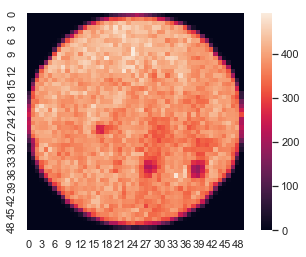

In [53]:
ax = sns.heatmap(nXY, square=True)

#### The function takes a substantial amount of time. Can it be accelerated?

## What  to do:

- If you want to accelerate/optimze a function, first think what the function does and what the possible bottlenecks.
- Profile the function to find out what the actual bottlenecks are.
- Thinks if bottlenecks can be fixed using PYTHON solutions (e.g, python fast libraries) first, and only if not, then try alternatives such as cython or numba.

## What not to do:

- Ignore advise above and try the approach of: "optimize first, think later".

## What I did:
- Exactly what I had not to do. Tried to optimize without profiling and without thinking (much).

## What catches the eye in function select_xy_sectors()?
- The auxiliary function selection_mask_xy_sectors() uses a dict and a dictionary to store a matrix of bools. A possible improvement could be to replace such construct by a fast numpy array of bools. 

In [57]:
def select_xy_sectors_np(dst, time_diffs, E, Q, bins_x, bins_y):
    """
    Return a dict of KrEvent organized by xy sector
    """

    def selection_mask_xy_sectors_np(values_x, values_y, bins_x,bins_y):
        """Returns a numpy array of bools"""
        
        nbins_x = len(bins_x) -1
        nbins_y = len(bins_y) -1
        mask = np.empty((nbins_x, nbins_y, len(values_x)), dtype=np.bool)

        for i in range(nbins_x):
            xvals = bins_x[i: i+2]
            sel_x = in_range(values_x, *bins_x[i: i+2])
            mask[i, :, :] = [sel_x & in_range(values_y, *bins_y[j: j+2]) for j in range(nbins_y)] 
    
        return mask

    MSK = selection_mask_xy_sectors_np(dst.X.values, dst.Y.values, bins_x, bins_y)
 
    RGES = {}
    for i in range(len(MSK)):
        msk = MSK[i]
        RGES[i] = [kr_event(dst, time_diffs, E, Q, sel_mask = m) for m in msk]
  
    return RGES





### Does it work better?

In [59]:
t0 = time.time()
KXY2 = select_xy_sectors_np(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
t1 = time.time()
print(f' python + np version = {t1 -t0}')

 python + np version = 8.199867248535156


#### Oooops, it actually takes longer! Here an example where the use of a "fast" numpy array is actually slower than the use of two "slow" python objects (a dict and a list). 

### Let's check that the results are the same, anyway

In [65]:
def data_frames_are_identical(df1, df2):
    df = df1 == df2 # the resulting df is a df of bools.
    
    # first all() gives a bool per column, creating a Series, seond all() gives a bool for the Series
    return df.eq(True).all().all() 

In [76]:
nXY2 = event_map(KXY2)

In [77]:
data_frames_are_identical(nXY, nXY2)

True

## Cython  then?
- So, if you consistently ignore the advise: profile!, the next step is to think that maybe cython will solve your problems. Let's try it:

In [69]:
%%cython
import  numpy as np
cimport numpy as np
from krcal.core.analysis_functions       import kr_event

cdef in_range(np.ndarray[np.float64_t, ndim=1] data, double vmin, double vmax):
    return (vmin <= data) & (data < vmax)


cdef selection_mask_xy_sectors_np(np.ndarray[np.float64_t, ndim=1] values_x, 
                                   np.ndarray[np.float64_t, ndim=1] values_y,
                                   np.ndarray[np.float64_t, ndim=1] bins_x,
                                   np.ndarray[np.float64_t, ndim=1] bins_y):
    """Returns a dict of selections arranged in a dict of xy bins"""
    
  
    cdef int nbins_x = len(bins_x) -1
    cdef int nbins_y = len(bins_y) -1
    cdef size_x = len(values_x)
    cdef int i, j
    cdef np.ndarray[np.uint8_t, ndim = 3, cast=True] mask
    mask = np.empty((nbins_x, nbins_y, size_x), dtype=np.bool)
    
         

    for i in range(nbins_x):
        xb = bins_x[i: i+2]
        sel_x = in_range(values_x, xb[0], xb[1])
        mask[i, :, :] = [sel_x & in_range(values_y, bins_y[j: j+2][0], bins_y[j: j+2][1]) for j in range(nbins_y)] 
    
    return mask


    

cpdef select_xy_sectors_cy(dst,
                           np.ndarray[np.float64_t, ndim=1] time_diffs,
                           np.ndarray[np.float64_t, ndim=1] E ,
                           np.ndarray[np.float64_t, ndim=1] Q ,
                           np.ndarray[np.float64_t, ndim=1] bins_x,
                           np.ndarray[np.float64_t, ndim=1] bins_y):
    """
    Return a dict of KrEvent organized by xy sector


    """

    cdef np.ndarray[np.uint8_t, ndim = 3, cast=True] MSK
    cdef np.ndarray[np.uint8_t, ndim = 2, cast=True] msk
    cdef dict RGES = {}
    cdef int i
    
    MSK = selection_mask_xy_sectors_np(dst.X.values, dst.Y.values, bins_x, bins_y)
    cdef int lmsk = len(MSK)
    
    for i in range(lmsk):
        msk = MSK[i]
        RGES[i] = [kr_event(dst, time_diffs, E, Q, sel_mask = m)  for m in msk]
 
    return RGES



### Are we faster now?

In [70]:
t0 = time.time()
KXY3 = select_xy_sectors_cy(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
t1 = time.time()
print(f' cython + np version = {t1 -t0}')

 cython + np version = 8.323078155517578


### cold Turkey!

In [78]:
nXY3 = event_map(KXY3)
data_frames_are_identical(nXY, nXY3)

True

## When everything else fails... Profile!

-Actually you will be much better off it you profile first.

In [79]:
cProfile.run('select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)')

         679325 function calls (669325 primitive calls) in 7.406 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.152    0.152    7.406    7.406 <string>:1(<module>)
     2500    0.003    0.000    0.003    0.000 <string>:1(__init__)
      104    0.000    0.000    0.000    0.000 __init__.py:1361(debug)
      104    0.000    0.000    0.000    0.000 __init__.py:1619(isEnabledFor)
      104    0.000    0.000    0.001    0.000 __init__.py:1996(debug)
        1    0.000    0.000    7.254    7.254 analysis_functions.py:399(select_xy_sectors)
        1    0.001    0.001    3.181    3.181 analysis_functions.py:432(selection_mask_xy_sectors)
       50    0.216    0.004    3.117    0.062 analysis_functions.py:444(<listcomp>)
       50    0.002    0.000    4.072    0.081 analysis_functions.py:457(<listcomp>)
     2500    3.789    0.002    4.070    0.002 analysis_functions.py:81(kr_event)
    25052    0.018    0.000    0.0

### The profile story:

- Almost all the time is spent in two functions: kr_event (3.8 s) and in_range (2.9 s), accounting for 6.7 s out of 7.4 s found by the profiler.

- The obvious lesson is that the creation of the KrEvent object has a heavy penaly in time. The second lesson is that, when it comes to the creation of selection the bottleneck is the function in_range() and not the handling of lists and dicts. 

- Not suprsingly our previous attempts have been futile. 

## How to improve?

- First: do we need the KrEvent object? Instead of creating a new object per bin we could simply store a selection of our input data frame (dst) directly. This would save us the penalty of creating the KrEvent. 

### First version: keep a numpy array for the selection, then keep a dictionary of lists of selections of the input data frame (e.g, avoid creating KrEvent objects)

In [81]:

def select_xy_sectors_df_np(dst, time_diffs, E, Q, bins_x, bins_y):
    """
    Return a dict of data frames organized by xy sector


    """

    def selection_mask_xy_sectors_np(values_x, values_y, bins_x,bins_y):
        """Returns a dict of selections arranged in a dict of xy bins"""
    
  
        
        nbins_x = len(bins_x) -1
        nbins_y = len(bins_y) -1
        mask = np.empty((nbins_x, nbins_y, len(values_x)), dtype=np.bool)

        for i in range(nbins_x):
            xvals = bins_x[i: i+2]
            sel_x = in_range(values_x, *bins_x[i: i+2])
            mask[i, :, :] = [sel_x & in_range(values_y, *bins_y[j: j+2]) for j in range(nbins_y)] 
    
        return mask


    RGES = {}
    MSK = selection_mask_xy_sectors_np(dst.X.values, dst.Y.values, bins_x, bins_y)
    
    for i in range(len(MSK)):
        msk = MSK[i]
        RGES[i] = [dst[m]  for m in msk]
 
    return RGES




In [82]:
t0 = time.time()
KXY4 = select_xy_sectors_df_np(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
t1 = time.time()
print(f' df + np version = {t1 -t0}')

 df + np version = 6.326003313064575


In [88]:
nXY4 = event_map(KXY4)
data_frames_are_identical(nXY, nXY4)

True

#### We have achieved some improvement by not creating KrEvent objects. What is the bottlneck now?

In [90]:
cProfile.run('select_xy_sectors_df_np(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)')

         1970888 function calls (1950888 primitive calls) in 6.628 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    37500    0.029    0.000    0.049    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
     5000    0.004    0.000    0.006    0.000 <frozen importlib._bootstrap>:416(parent)
        1    1.318    1.318    4.183    4.183 <ipython-input-81-92b7220e68bb>:11(selection_mask_xy_sectors_np)
       50    0.206    0.004    2.816    0.056 <ipython-input-81-92b7220e68bb>:23(<listcomp>)
       50    0.003    0.000    2.280    0.046 <ipython-input-81-92b7220e68bb>:33(<listcomp>)
        1    0.000    0.000    6.464    6.464 <ipython-input-81-92b7220e68bb>:4(select_xy_sectors_df_np)
        1    0.164    0.164    6.628    6.628 <string>:1(<module>)
     2500    0.002    0.000    0.004    0.000 __init__.py:205(iteritems)
    17500    0.007    0.000    0.063    0.000 _methods.py:42(_any)
     2500    0.005    0.00

#### The bottleneck is in the selection maps. But since we have decided to stick to the Data Frame dst and not to create a new object we can make the selections in the dst itself, aoviding the construction of the big np.array of selections. 

In [92]:
def select_xy_sectors_df(dst, time_diffs, E, Q, bins_x, bins_y):
    """
    Return a dict of data frames organized by xy sector


    """

    RGES = {}
    nbins_x = len(bins_x) -1
    nbins_y = len(bins_y) -1

    for i in range(nbins_x):
        xvals = bins_x[i: i+2]
        dstx = dst[in_range(dst.X, *bins_x[i: i+2])]
        RGES[i] = [dstx[in_range(dstx.Y, *bins_y[j: j+2])] for j in range(nbins_y)]
            
    return RGES

In [93]:
t0 = time.time()
KXY5 = select_xy_sectors_df(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)
t1 = time.time()
print(f' df version = {t1 -t0}')

 df version = 2.688533067703247


### Bingo. More than a factor two improvement in performance, a more concise code and a simpler concept (avoid the creation of an object that is not strictly necessary, since all the info is in the dst anyway)

In [89]:
nXY5 = event_map(KXY5)
data_frames_are_identical(nXY, nXY5)

True

In [91]:
cProfile.run('select_xy_sectors_df(dst, DT, dst.S2e.values, dst.S2q.values, krBins.X, krBins.Y)')

         5155186 function calls (5092086 primitive calls) in 4.357 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    58650    0.043    0.000    0.082    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
     5100    0.004    0.000    0.006    0.000 <frozen importlib._bootstrap>:416(parent)
       50    0.027    0.001    3.950    0.079 <ipython-input-86-40e162c82f0b>:18(<listcomp>)
        1    0.010    0.010    4.339    4.339 <ipython-input-86-40e162c82f0b>:4(select_xy_sectors_df)
        1    0.017    0.017    4.356    4.356 <string>:1(<module>)
     2550    0.003    0.000    0.004    0.000 __init__.py:205(iteritems)
     5100    0.008    0.000    0.343    0.000 _decorators.py:136(wrapper)
    17850    0.008    0.000    0.077    0.000 _methods.py:42(_any)
    10200    0.005    0.000    0.007    0.000 _validators.py:221(validate_bool_kwarg)
     5100    0.011    0.000    0.020    0.000 _validators.py:325(validate

#### All the time is now consumed by PANDAS operations. Since the PANDAS library is fast (and cannot be accelerated by cython or numba since its underlying functions are written in C etc), we can conclude that we have optimized the function. 

## Simplifying the function.
- But notice that we are now passing three vectors to the function that we are not using. Those vectors were added to the KrEvent object. We can choose to add them to the dataFrame dst *before* the selection, or use other solutions. However, what is clear is that the function select_xy_sectors() should do only what it advertises, that is select the sectors (not adding extra variables, etc). Thus, final version:

In [95]:
def select_xy_sectors_dst(dst : DataFrame, bins_x : np.array, bins_y : np.array)->Dict[int, List[DataFrame]]:
    """
    Return a dict of data frames organized by xy sector

    """

    RGES = {}
    nbins_x = len(bins_x) -1
    nbins_y = len(bins_y) -1

    for i in range(nbins_x):
        xvals = bins_x[i: i+2]
        dstx = dst[in_range(dst.X, *bins_x[i: i+2])]
        RGES[i] = [dstx[in_range(dstx.Y, *bins_y[j: j+2])] for j in range(nbins_y)]
            
    return RGES

In [96]:
t0 = time.time()
KXY6 = select_xy_sectors_dst(dst, krBins.X, krBins.Y)
t1 = time.time()
print(f' df version = {t1 -t0}')

 df version = 2.5888450145721436


In [97]:
nXY6 = event_map(KXY6)
data_frames_are_identical(nXY, nXY6)

True

## END